<h1 style="text-align: center;">Support Vector Machines</h1>

The aim of this lab is to get hands-on experience with implementing and using support vector machines

In [4]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import random
import math

### Generating Test Data
Generation of two-dimensional data, i.e., points in a plane. The data will have the form of N x 2 Array.


In [5]:
#np.random.seed(100)    # to get the same random numbers

classA = np.concatenate(
    (np.random.randn(10, 2) * 0.2 + [1.5, 0.5],
    np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

N = inputs.shape[0]   # Number of rows (samples)

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

### Kernels definition

In [6]:
def LinearKernel(x, y):
    return np.dot(x, y)

def PolynomialKernel(x, y, p=3):
    '''Optional parameter p controls the degree of the polynomial'''
    return (1 + np.dot(x, y)) ** p

def RBFKernel(x, y, sigma=1.0):
    '''Optional parameter sigma controls the width of the Gaussian'''
    return math.exp(-np.linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

Kernel = RBFKernel

### SVM implementation

Generation of the Pmatrix, needed in function `objective`. This matrix is computed outside the function for efficiency reasons.

In [7]:
Pmatrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Pmatrix[i, j] = targets[i] * targets[j] * Kernel(inputs[i], inputs[j])

Implement the function `objective`, which implements the formula needed for the *dual problem* formulation.
The dual problem is used since it meakes possible to use the *kernel trick*.

In [8]:
def objective(alpha):
    '''Implement expression (4)'''
    return 0.5 * np.dot(alpha, np.dot(alpha, Pmatrix)) - np.sum(alpha)

Implement the function `nonzero`, which implements the equality constraint. 

In [9]:
def zerfun(alpha):
    '''Implement expression (10), i.e., the equality constraint'''
    return np.dot(alpha, targets)

Call the `minimize` function from the `scipy.optimize` package, which will find and return the vector which minimize the function *objective* within the bounds *B* and the constraints *XC* 

In [10]:
'''Initial guess of alpha'''
start = np.zeros(N)

'''Set B, i.e., the bounds for alpha vector'''

#B = [(0, None) for b in range(N)]  for having only lower bound

C = 10000
B = [(0, C) for b in range(N)]  # for having both lower and upper bounds

'''Set the constraint, in this case the zerofun function. XC is given as a dictionary'''
XC = {'type':'eq', 'fun':zerfun}

'''Call to minimize function'''
ret = minimize(objective, start, bounds=B, constraints=XC)

if (not ret['success']):    # success is a Boolean flag indicating if the optimizer exited successfully
    raise ValueError('Cannot find optimal solution')

alpha = ret['x']    # x is the solution array

Only few elements of the alpha vector will be non-zero. Those non-zero values are ours Support Vectors, hence we save them in a separate data structure.

In [11]:
# extract non-zero alphas

nonzero = [(alpha[i], inputs[i], targets[i]) for i in range(N) if abs(alpha[i]) > 1e-5]

Calculation of the *b* threshold, needed in the function `indicator`.

In [12]:
def bvalue():
    '''Implement expression (7)'''
    sum = 0
    for value in nonzero:
        sum += value[0] * value[2] * Kernel(value[1], nonzero[0][1])
    return sum - nonzero[0][2]

Implement the function `indicator`, which classifis new data points.

In [13]:
def indicator(x, y):
    '''Implement expression (6)'''
    sum = 0
    for value in nonzero:
        sum += value[0] * value[2] * Kernel(value[1], [x, y])
    return sum - bvalue()

Plot the results of the classification. The points are colored according to their class. The Support Vectors are marked with a green cross.

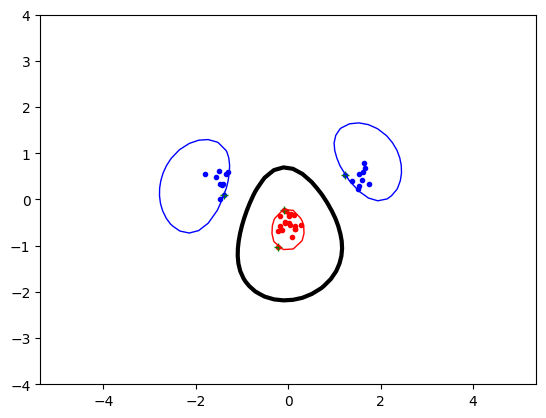

In [14]:
# Plot data points

plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
plt.plot([p[1][0] for p in nonzero], [p[1][1] for p in nonzero], 'g+')
plt.axis('equal')   # set the axes to the same scale

# Plot the decision boundary

xgrid = np.linspace(-5, 5)
ygrid = np.linspace(-4, 4)
grid = np.array([[indicator(x, y) for x in xgrid] for y in ygrid])
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

plt.savefig('resources/svmplot.png')  # save a copy in a file
plt.show()